In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys

import os, sys

%matplotlib inline

In [2]:
from box import Box
import glob

In [3]:
TOP = os.getcwd().replace("notebooks/tt", "")
D1 = TOP + 'data/'
figures_dir = TOP + 'manuscript/figures/'

### DATA

In [4]:
CHM1 = pd.read_csv(D1 + 'S7-chem.tsv', sep='\t', low_memory=False)
CHM1 = CHM1.replace(['-'], np.nan)
CHM1.isnull().values.any()
CHM1 = CHM1.dropna()
CHM1
CHM1_nm = CHM1[['DTXSID', 'PREFERRED_NAME']].set_index('DTXSID')
X = CHM1 = CHM1.drop(['PREFERRED_NAME'], axis=1).set_index('DTXSID')

CHM11 = Box()
for i in set([i[0] for i in X.columns.str.split('_') ]):
    CHM11[i] =  X[X.columns[X.columns.str.match(i)]]
CHM11['all'] = X

In [5]:
BIO1 = pd.read_csv(D1+'S2-bio.tsv', sep='\t') 
BIO1 = BIO1.rename(columns = {'dsstox_substance_id':'DTXSID'})

BIO1 = BIO1.drop(['chnm', 'casn'], axis = 1).set_index('DTXSID')
BIO11 = Box()
for i in set([i[0] for i in BIO1.columns.str.split('_')]):
    BIO11[i]=BIO1[BIO1.columns[BIO1.columns.str.match(i)]]
BIO11['all']=BIO1

In [6]:
TOX1 = pd.read_csv(D1+'S1-tox.tsv', sep='\t')

TOX1 = TOX1.rename(columns = {'dsstox_substance_id':'DTXSID'})
TOX1 = TOX1.drop(['preferred_name'], axis=1).set_index('DTXSID')
#set([i[0] for i in TOX1.columns.str.split('_')])
TOX11 = Box()
for i in set([i[0] for i in TOX1.columns.str.split('_')]):
    TOX11[i] = TOX1[TOX1.columns[TOX1.columns.str.match(i)]]
TOX11['all'] = TOX1

In [7]:
DATA = Box(chm=CHM11,bio=BIO11,tox=TOX11)
DATA['bc'] = Box()

for c,b in [(i,j) for i in CHM11.keys() for j in BIO11.keys()]:
    print(b,c)
    DATA['bc']['{}_{}'.format(b,c)] = CHM11[c].merge(BIO11[b],left_index=True,right_index=True)

assay mrgn
gene mrgn
all mrgn
assay tptr
gene tptr
all tptr
assay toxp
gene toxp
all toxp
assay all
gene all
all all


In [8]:
[e for e in TOX1.columns if 'liver' in e]

['chr_liver',
 'dev_liver',
 'dev_premature_delivery',
 'dnt_liver',
 'mgr_liver',
 'neu_liver',
 'oth_liver',
 'rep_liver',
 'sac_liver',
 'sub_liver']

In [9]:
effects = ['chr_liver', 'dev_liver']

### DEF getDATA

In [10]:
def getData(b,dt='chm',st='all',Data=DATA):
    """
    Return an input and output dataframe for analysis
    
    b = toxicity class
    dt= input data type (chm or bio)
    st= inpute subdata type ()
    """
    
    Y = Data.tox.all[b].dropna()
    INT=Data[dt][st].index.intersection(Y.index)
    if len(INT)>0:
        Yf= Y.copy()[INT]
        Yf[Yf>0]=1
        Yb = Yf.copy()
        Yb = Yb.astype(np.int32)
        X  = Data[dt][st].loc[INT].fillna(0)
    else:
        pass
    
    return X,Yb

In [11]:
#getData('chr_liver',dt='chm',st='mrgn')


In [111]:
mydict = {}
for e in effects:
    data = getData(e,dt='chm',st='mrgn')
    mydict[e] = data

In [20]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings

## Balance with RandomUnderSampler

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score, precision_score
from collections import Counter

### Model Validation Using chm descriptors After Undersampling

In [22]:
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
#from sklearn.tree import DecisionTreeClassifier

from genra.rax.skl.cls import *
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline

In [116]:
def model_cv(d,  label = None):
    Res = []
    Est = [('Random Forest', RandomForestClassifier(random_state=42)),
          ('NB', BernoulliNB()),
          ('LR', LogisticRegression(max_iter=1000)),
          ('Gradient Boosting', GradientBoostingClassifier()),
          ('SVC', SVC(gamma='auto',probability=True)),
          ('KNN',KNeighborsClassifier()),
          ('ANN1',MLPClassifier(solver='sgd')),
          ('GenRA', GenRAPredClass(n_neighbors=10,metric='jaccard'))]
    X, Y = d
    increments = np.arange(50, np.sum(Y==0), 10)
    for increment in increments:
        for model in Est:
                LR, Clf = model
                steps = [('undersampler', RandomUnderSampler(random_state = 42, sampling_strategy={0:  increment, 1: increment })), model]
                pipeline = Pipeline(steps=steps)
                score = cross_validate(pipeline, X, Y,
                           cv=StratifiedKFold(n_splits = 5),
                           scoring= {'accuracy': make_scorer(accuracy_score),
                                     'f1': make_scorer(f1_score),
                                     'sensitivity': make_scorer(recall_score),
                                     'specificity': make_scorer(recall_score,pos_label=0),
                                    'precision': make_scorer(precision_score)},
                           n_jobs=-1, verbose=1, return_estimator = True)
    #elapsed_time = datetime.now() - start_time
                SC = pd.DataFrame(score)
                SC.insert(0,'LR',LR)
                Res.append(SC)
    return Res

In [117]:
def plugin(d, label=None):
    summary = {}
    X, Y = d
    summary['label'] = label
    summary['score'] = model_cv(d)
    
    return summary

In [118]:
#plugin(mydict['chr_liver'])

In [119]:
chm_summaries = []
for k in list(mydict.keys()):
    try:
        chm_summaries.append(plugin(mydict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [121]:
myperm2 = {}
myperm = {}
for i in range(len(chm_summaries)):
    k = chm_summaries[i]['label']
    Perf = pd.concat(chm_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    myperm[k] = Perf_agg
    myperm2[k] = Perf       

In [122]:
Perf_mgrn = pd.concat(myperm)    
Perf_mgrn_raw = pd.concat(myperm2)   

In [182]:
def prep_df(df):
    rs = []
    df1 = df.reset_index()
      
    for idx, est in enumerate(df1['estimator']):
          rs.append(str(est.named_steps['undersampler']))
    
    df1['est'] = rs
    return df1

In [184]:
Perf_mgrn_raw1 = prep_df(Perf_mgrn_raw)

In [185]:
Perf_mgrn_raw1.to_csv(D1 + '/under_sampling_140823.csv' )
#Perf_mgrn.to_csv(D1 + '/ML_under_mgrn_summary_190123.csv' )

## Model Validation Using Bio (gene hitc) Descriptors

In [186]:
bio_dict = {}
for e in effects:
    data = getData(e,dt='bio',st='gene')
    bio_dict[e] = data

In [187]:
bio_summaries = []
for k in list(bio_dict.keys()):
    try:
        bio_summaries.append(plugin(bio_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [188]:
bio_perm2 = {}
bio_perm = {}
for i in range(len(bio_summaries)):
    k = bio_summaries[i]['label']
    Perf = pd.concat(bio_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    bio_perm[k] = Perf_agg
    bio_perm2[k] = Perf

In [189]:
Perf_bio = pd.concat(bio_perm)  
Perf_bio_raw = pd.concat(bio_perm2)  

In [190]:
Perf_bio_raw1 = prep_df(Perf_bio_raw)

In [191]:
Perf_bio_raw1.to_csv(D1 + '/ML_under_bio_posthoc_140123.csv' )
#Perf_bio.to_csv(D1 + '/ML_under_bio_summary_190123.csv' )        
        

## Model Validation Using Hybrid (chm(mrgn) + bio(hitc)) Descriptors

In [192]:
hybrid_dict = {}
for e in effects:
    data = getData(e,dt='bc',st='gene_mrgn')
    hybrid_dict[e] = data

In [193]:
hybrid_summaries = []
for k in list(hybrid_dict.keys()):
    try:
        hybrid_summaries.append(plugin(hybrid_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [194]:
myperm2 = {}
myperm = {}
for i in range(len(hybrid_summaries)):
    k = hybrid_summaries[i]['label']
    Perf = pd.concat(hybrid_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    myperm[k] = Perf_agg
    myperm2[k] = Perf

In [195]:
Perf_hybrid = pd.concat(myperm)  
Perf_hybrid_raw = pd.concat(myperm2) 

In [197]:
Perf_hybrid_raw1 = prep_df(Perf_hybrid_raw)

In [198]:
Perf_hybrid_raw1.to_csv(D1 + '/ML_under_hybrid_posthoc_140823.csv' )
#Perf_hybrid.to_csv(D1 + '/ML_under_hybrid_summary_190123.csv' )  

## Model Validation Using All Chm (mrgn + tptr + toxp) Descriptors     

In [199]:
ca_dict = {}
for e in effects:
    data = getData(e,dt='chm',st='all')
    ca_dict[e] = data




In [200]:
ca_summaries = []
for k in list(ca_dict.keys()):
    try:
        ca_summaries.append(plugin(ca_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [201]:
ca_perm2 = {}
ca_perm = {}
for i in range(len(ca_summaries)):
    k = ca_summaries[i]['label']
    Perf = pd.concat(ca_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    ca_perm[k] = Perf_agg
    ca_perm2[k] = Perf

In [202]:
Perf_ca = pd.concat(ca_perm)  
Perf_ca_raw = pd.concat(ca_perm2)  

In [203]:
Perf_ca_raw1 = prep_df(Perf_ca_raw)

In [204]:
Perf_ca_raw1.to_csv(D1 + '/ML_under_ca_posthoc_140823.csv' )
#Perf_ca.to_csv(D1 + '/ML_under_ca_summary_190123.csv' )  

## Model Validation Using All Chm + bio (mrgn + tptr + toxp + bio) Descriptors

In [205]:
bc_dict = {}
for e in effects:
    data = getData(e,dt='bc',st='gene_all')
    bc_dict[e] = data

In [206]:
bc_summaries = []
for k in list(bc_dict.keys()):
    try:
        bc_summaries.append(plugin(bc_dict[k], k))
    except Exception as error:
        print(k)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [207]:
bc_perm2 = {}
bc_perm = {}
for i in range(len(bc_summaries)):
    k = bc_summaries[i]['label']
    Perf = pd.concat(bc_summaries[i]['score'])
    Perf_agg = Perf.groupby(['LR']).aggregate(dict(test_f1=[np.mean,np.std],
                                    test_sensitivity=[np.mean,np.std],
                                    test_specificity=[np.mean,np.std],
                                    test_accuracy=[np.mean,np.std],
                                    test_precision=[np.mean,np.std],))\
    .round(decimals=3)
    bc_perm[k] = Perf_agg
    bc_perm2[k] = Perf

In [208]:
Perf_bc = pd.concat(bc_perm)  
Perf_bc_raw = pd.concat(bc_perm2)  

In [209]:
Perf_bc_raw1 = prep_df(Perf_bc_raw)

In [210]:
Perf_bc_raw1.to_csv(D1 + '/ML_under_cba_posthoc_140823.csv' )
#Perf_bc.to_csv(D1 + '/ML_under_cba_all_summary_190123.csv' )    

/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GenRAPredClass was fitted with feature names
  warnings.warn(
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/grace/anaconda3/envs/aim/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perce

In [212]:
#data = dict( tox = ['chr_liver', 'chr_liver','chr_liver','chr_liver','chr_liver', 'dev_liver','dev_liver','dev_liver','dev_liver','dev_liver'], dt = ['mrgn', 'gene', 'cb', 'ca', 'cba', 'mrgn', 'gene', 'cb', 'ca', 'cba', ] ,pos = [128,134,128,128,128, 43,47,43,43,43], neg = [128,134,128,128,128,43,47,43,43,43])

In [213]:
#df_counts = pd.DataFrame(data)

In [214]:
#df_counts['balance'] = 'random'
#df_counts['sample'] = 'under'

In [215]:
#df_counts

In [222]:
Perf_mgrn_raw1.drop(['index', 'level_1','fit_time', 'score_time',
       'estimator'], axis = 1).columns

Index(['level_0', 'LR', 'test_accuracy', 'test_f1', 'test_sensitivity',
       'test_specificity', 'test_precision', 'est'],
      dtype='object')

In [231]:
def pref_files(df, dt, st, bl):
    #df = df.drop([0,1])
    df['dt'] = dt 
    df['balance'] = bl
    df['sampling'] = st
    #df = pd.merge(df, df_counts, on = 'tox', how = 'left')
    return df

In [232]:
#pref_files(Perf_mgrn, 'mgrn')

In [233]:
mylst = ['mrgn', 'gene', 'cb', 'ca', 'cba']

In [234]:
mylst2 = list(zip(mylst, [Perf_mgrn_raw1, 
Perf_bio_raw1, 
Perf_hybrid_raw1,
Perf_ca_raw1, 
Perf_bc_raw1 ], ))

In [236]:
mylst3 = []
for e in mylst2:
    a,b = e
    mylst3.append(pref_files(b,a, st = 'under', bl = 'random'))

In [237]:
final_df = pd.concat(mylst3)

In [241]:
final_df = final_df[['level_0','LR', 'test_accuracy', 'test_f1', 'test_sensitivity',
       'test_specificity', 'test_precision', 'est', 'dt', 'balance',
       'sampling']]

In [11]:
#final_df

In [12]:
df_melt = final_df[(final_df['level_0'] == 'chr_liver') & (final_df['test_f1'].notnull())].melt(id_vars = ['level_0', 'LR', 'dt', 'est'], value_vars = 'test_f1')

In [13]:
df_melt.head()

,level_0,LR,dt,est,variable,value
0,chr_liver,Random Forest,mrgn,"RandomUnderSampler(random_state=42, sampling_s...",test_f1,0.564706
1,chr_liver,Random Forest,mrgn,"RandomUnderSampler(random_state=42, sampling_s...",test_f1,0.595238
2,chr_liver,Random Forest,mrgn,"RandomUnderSampler(random_state=42, sampling_s...",test_f1,0.688889
3,chr_liver,Random Forest,mrgn,"RandomUnderSampler(random_state=42, sampling_s...",test_f1,0.450704
4,chr_liver,Random Forest,mrgn,"RandomUnderSampler(random_state=42, sampling_s...",test_f1,0.564103


In [14]:
import seaborn as sns

In [19]:
import re

In [20]:
pattern = r'sampling_strategy=\{[^\}]*\}'

In [22]:
df_melt.shape

(1200, 6)

In [23]:
len([re.search(pattern, e) for e in df_melt['est']])

1200

In [26]:
df_melt['sampling_strategy'] = [re.search(pattern, e).group(0) for e in df_melt['est']]

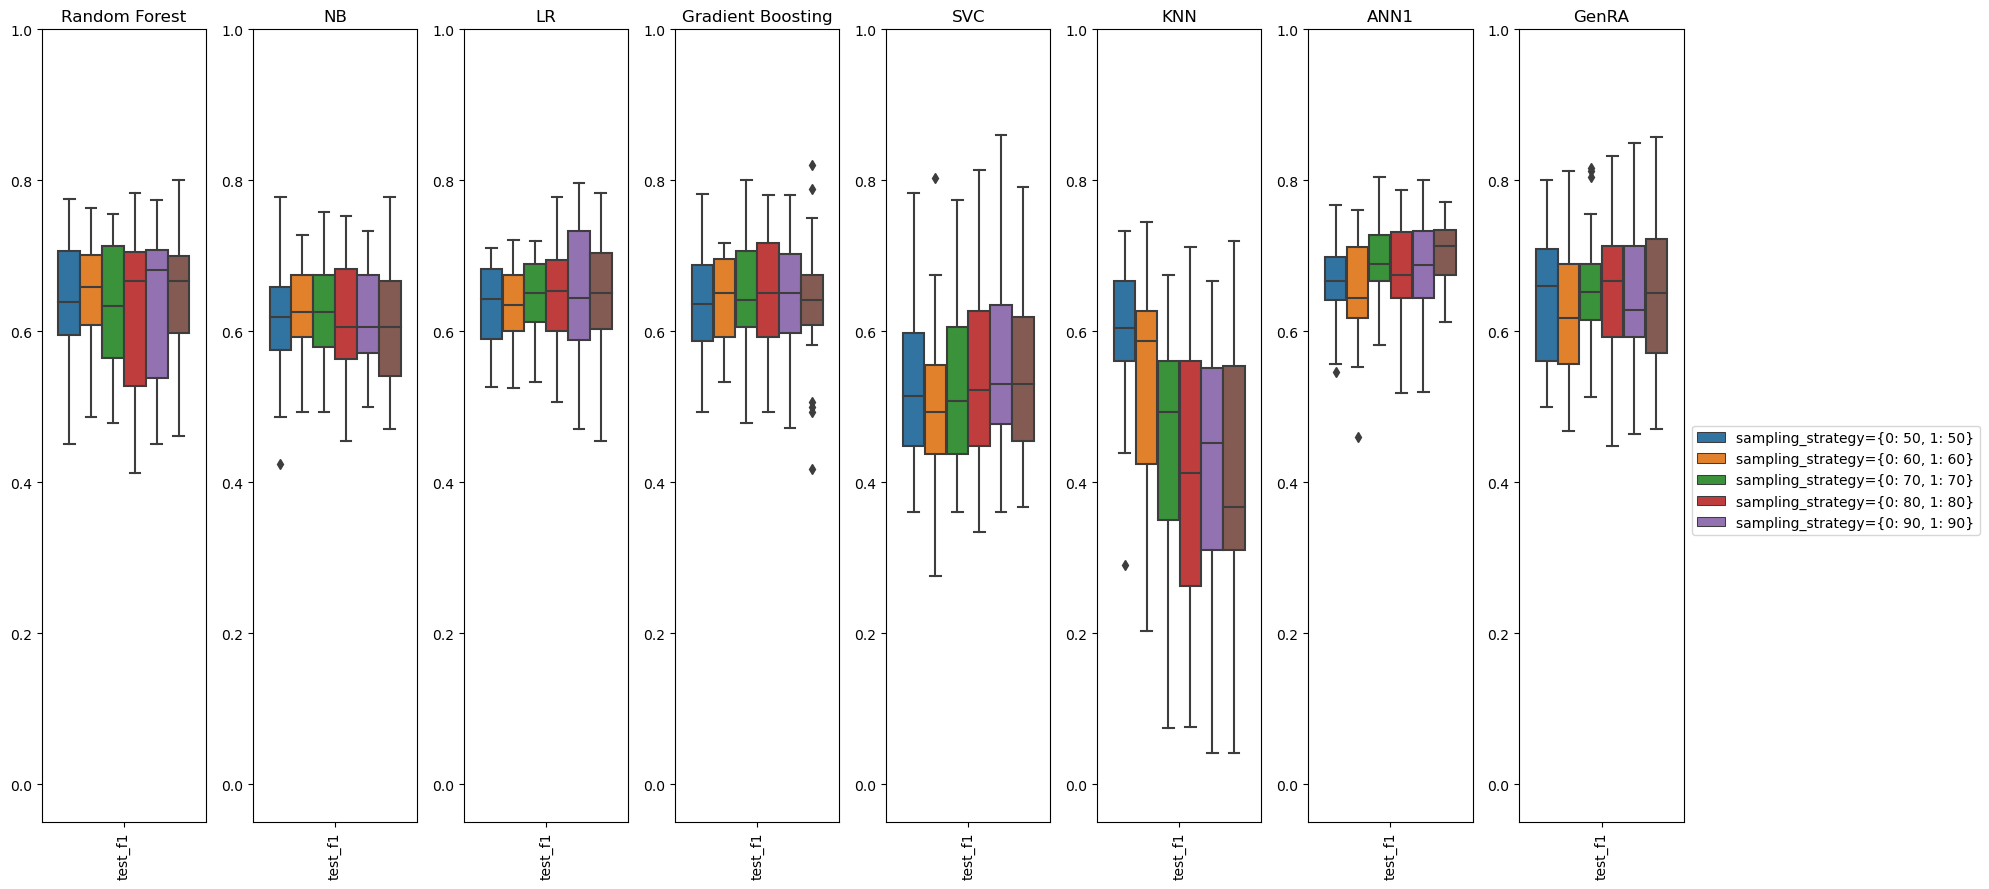

In [28]:
f = plt.figure(figsize = (20,9))
k=0
for e in df_melt.LR.unique():
    k+=1
    ax = plt.subplot(1, 8, k)
    g = sns.boxplot(x = 'variable', y = 'value',  hue = 'sampling_strategy', data = df_melt[(df_melt['LR'] == e) ])
    ax.set_title(e)
    for xlab in ax.get_xticklabels():xlab.set_rotation(90)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(-0.05,1)
    ax.get_legend().remove()
    plt.subplots_adjust(hspace = 0.8)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:5], labels[0:5], bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
plt.tight_layout()
f.savefig(figures_dir+'Figure8r.png', dpi = 300)

In [261]:
writer = pd.ExcelWriter(D1+'random_under_all_posthoc_140823.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_df.to_excel(writer, sheet_name = 'all')

writer.save()

In [6]:
final_df = pd.read_excel(D1+'random_under_all_posthoc_140823.xlsx', index_col = [0])

In [7]:
final_df

,level_0,LR,test_accuracy,test_f1,test_sensitivity,test_specificity,test_precision,est,dt,balance,sampling
0,chr_liver,Random Forest,0.493151,0.564706,0.500000,0.480000,0.648649,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
1,chr_liver,Random Forest,0.534247,0.595238,0.531915,0.538462,0.675676,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
2,chr_liver,Random Forest,0.616438,0.688889,0.659574,0.538462,0.720930,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
3,chr_liver,Random Forest,0.465753,0.450704,0.340426,0.692308,0.666667,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
4,chr_liver,Random Forest,0.527778,0.564103,0.468085,0.640000,0.709677,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
...,...,...,...,...,...,...,...,...,...,...,...
995,dev_liver,GenRA,NaN,NaN,NaN,NaN,NaN,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under
996,dev_liver,GenRA,NaN,NaN,NaN,NaN,NaN,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under
997,dev_liver,GenRA,NaN,NaN,NaN,NaN,NaN,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under
998,dev_liver,GenRA,NaN,NaN,NaN,NaN,NaN,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under


In [8]:
final_df2 = final_df[(final_df['level_0'] == 'chr_liver') & (final_df['test_f1'].notnull())]

In [9]:
final_df2

,level_0,LR,test_accuracy,test_f1,test_sensitivity,test_specificity,test_precision,est,dt,balance,sampling
0,chr_liver,Random Forest,0.493151,0.564706,0.500000,0.480000,0.648649,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
1,chr_liver,Random Forest,0.534247,0.595238,0.531915,0.538462,0.675676,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
2,chr_liver,Random Forest,0.616438,0.688889,0.659574,0.538462,0.720930,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
3,chr_liver,Random Forest,0.465753,0.450704,0.340426,0.692308,0.666667,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
4,chr_liver,Random Forest,0.527778,0.564103,0.468085,0.640000,0.709677,"RandomUnderSampler(random_state=42, sampling_s...",mrgn,random,under
...,...,...,...,...,...,...,...,...,...,...,...
235,chr_liver,GenRA,0.794521,0.857143,0.937500,0.520000,0.789474,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under
236,chr_liver,GenRA,0.684932,0.762887,0.787234,0.500000,0.740000,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under
237,chr_liver,GenRA,0.602740,0.632911,0.531915,0.730769,0.781250,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under
238,chr_liver,GenRA,0.630137,0.674699,0.595745,0.692308,0.777778,"RandomUnderSampler(random_state=42, sampling_s...",cba,random,under


In [266]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [271]:
final_df2.dt.unique()

array(['mrgn', 'gene', 'cb', 'ca', 'cba'], dtype=object)

In [272]:
anova_res = {}
for x in final_df2.LR.unique():
    for y in final_df2.dt.unique():
        ols('test_f1 ~ C(est)', data=final_df2[(final_df2['dt']== y) & (final_df2['LR'] == x )] ).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        anova_res[(x,y)] = aov_table



In [276]:
anova_res[('Random Forest',
  'mrgn')]['PR(>F)'][0]

0.9491951484507253

In [278]:
for k,v in anova_res.items():
    if v['PR(>F)'][0] < 0.05:
        print(k)